# Import Packages

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


# Import Data after Webscraping

In [3]:
data = pd.read_csv('Friends_transcripts.csv')

# Data Inspection

In [4]:
pd.set_option('display.max_colwidth', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51766 entries, 0 to 51765
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Episodes       51766 non-null  object
 1   Episode_Names  51766 non-null  object
 2   Characters     51766 non-null  object
 3   Lines          51766 non-null  object
dtypes: object(4)
memory usage: 1.6+ MB


In [5]:
data.head()

,Episodes,Episode_Names,Characters,Lines
0,101,Monica Gets A Roommate,MONICA,There's nothing to tell! He's just some guy I work with!
1,101,Monica Gets A Roommate,JOEY,"C'mon, you're going out with the guy! There's gotta be something wrong with him!"
2,101,Monica Gets A Roommate,CHANDLER,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?"
3,101,Monica Gets A Roommate,PHOEBE,"Wait, does he eat chalk?"
4,101,Monica Gets A Roommate,PHOEBE,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!"


> It seems that character names are sometimes written in captial cases. and sometimes in lower case.

In [6]:
# Lets make the character names consistent and add a new column 'Season'
data.Characters = data.Characters.apply (lambda x:  str.upper(x))
data['Season']= data.Episodes.apply(lambda x: int(x[0]) if len(x) in [3,7] else int(x[:2]))
data_columns = list(data.columns)
data_columns

['Episodes', 'Episode_Names', 'Characters', 'Lines', 'Season']

Text(0.5, 1.0, 'Total Number of Lines for Top 15 Characters in the Show ')

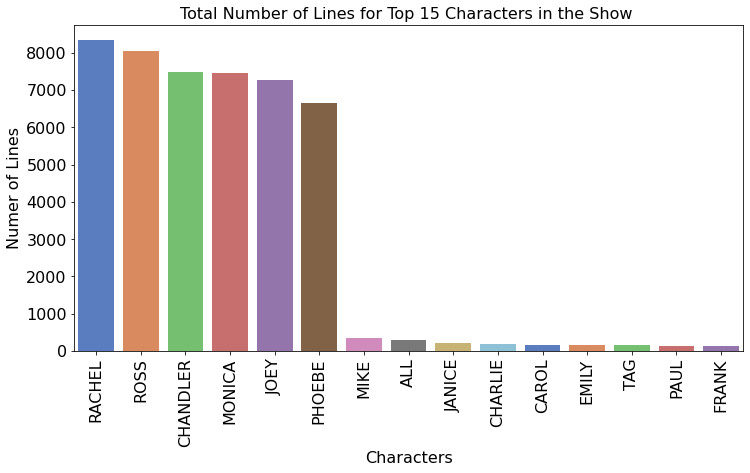

In [7]:
Characters_per_rank = (data.Characters.value_counts()).index 
data_for_count_plot = data[data.Characters.isin (Characters_per_rank[0:15])]
plt.figure(figsize = (12, 6))
sns.countplot(x= 'Characters', order = Characters_per_rank[0:15], palette = 'muted', data = data_for_count_plot)
plt.xlabel("Characters", fontsize=16)
plt.ylabel("Numer of Lines", fontsize=16)
plt.xticks(rotation = 90,  fontsize=16)
plt.yticks(  fontsize= 16)
plt.title("Total Number of Lines for Top 15 Characters in the Show ",fontsize=16)

In [8]:
data_lines_per_season = pd.pivot_table(data_for_count_plot,index=["Characters","Season"],values=["Lines"],aggfunc='count')
data_lines_per_season = data_lines_per_season.reset_index()
data_lines_per_season_pivot = data_lines_per_season.pivot(index='Season', columns='Characters', values='Lines')

In [9]:
data_lines_per_season_pivot

Characters,ALL,CAROL,CHANDLER,CHARLIE,EMILY,FRANK,JANICE,JOEY,MIKE,MONICA,PAUL,PHOEBE,RACHEL,ROSS,TAG
Season,,,,,,,,,,,,,,,
1,90.0,73.0,764.0,NaN,NaN,NaN,38.0,612.0,NaN,854.0,17.0,592.0,822.0,915.0,NaN
2,8.0,29.0,227.0,NaN,NaN,NaN,7.0,172.0,NaN,243.0,NaN,193.0,259.0,278.0,NaN
3,53.0,27.0,783.0,NaN,NaN,79.0,62.0,738.0,3.0,814.0,NaN,764.0,880.0,998.0,NaN
4,38.0,11.0,842.0,NaN,131.0,28.0,27.0,748.0,4.0,712.0,NaN,652.0,859.0,760.0,NaN
5,44.0,7.0,936.0,NaN,29.0,25.0,14.0,921.0,NaN,891.0,NaN,805.0,902.0,866.0,NaN
6,23.0,13.0,1001.0,NaN,NaN,NaN,1.0,871.0,NaN,870.0,116.0,760.0,950.0,876.0,NaN
7,15.0,10.0,847.0,NaN,NaN,NaN,18.0,930.0,NaN,899.0,NaN,798.0,1092.0,821.0,131.0
8,3.0,NaN,576.0,NaN,NaN,NaN,24.0,800.0,NaN,725.0,NaN,698.0,1004.0,873.0,15.0
9,3.0,NaN,822.0,133.0,NaN,NaN,10.0,755.0,227.0,781.0,NaN,703.0,802.0,787.0,NaN


<Figure size 864x432 with 0 Axes>

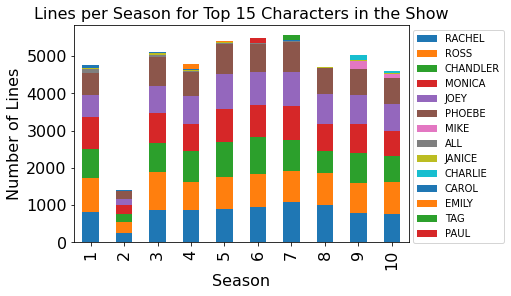

In [10]:
data_lines_per_season_pivot = data_lines_per_season.pivot(index='Season', columns='Characters', values='Lines')
data_lines_per_season_pivot.fillna(0)

#sns.set()
plt.figure(figsize=(12,6))
data_lines_per_season_pivot.loc[:,Characters_per_rank[:14]].plot.bar(stacked=True)

plt.xlabel( "Season",fontsize=16)
plt.ylabel("Number of Lines", fontsize=16)
plt.xticks(  fontsize= 16,rotation = 90)
plt.yticks(  fontsize= 16)
plt.title("Lines per Season for Top 15 Characters in the Show",fontsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1),prop={'size':10})

# Data Cleaning

In [11]:
# Define a function to return the wordnet object value corresponding to the POS tag

import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        
        return wordnet.ADJ

    elif pos_tag.startswith('V'):

        return wordnet.VERB

    elif pos_tag.startswith('N'):

        return wordnet.NOUN

    elif pos_tag.startswith('R'):

        return wordnet.ADV

    else:

        return wordnet.NOUN

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data

In [12]:
# write a function to clean text    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')

def clean_text(text):
    #print(text)
    # lower text
    text = text.lower()

    # tokenize text for space and \n
    text = re.split('\s+|\n',text)
    
    # remove puncutation
    text = [word.strip(string.punctuation) for word in text]

    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]

    # remove stop words
    stop = set(stopwords.words('english'))
    text = [x for x in text if x not in stop]

    # remove empty tokens
    text = [t for t in text if len(t) > 0]

    # pos tag text
    pos_tags = pos_tag(text)

    # create a (word, pos_tag) tuple for each word in text and then lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]

    # remove words with only one letter
    text = [t for t in text if len(t) > 1]

    # join all
    text = " ".join(text)

    return(text)

# call the function to clean text data
data["Lines"] = data["Lines"].apply(lambda x: clean_text(x))
data["Lines"].head()

# Eliminate any row with no entry fordata['Lines'] after cleaning 
data['Lines'].replace('', np.NaN, inplace=True)
data.dropna(inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
data.head()

,Episodes,Episode_Names,Characters,Lines,Season
0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1
1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1
2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1
3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1
4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1


In [13]:
# keep a list of all words and a set for all characters for future use in the code
import itertools
line_tokenized = [ re.split(' ',text) for text in data['Lines'].dropna()]
all_words = list(itertools.chain.from_iterable(line_tokenized))
all_characters = set(data.Characters)

# Interactive EDA: Visualize Word/Letter Density for Different Actors

In [56]:
# create figure
import ipywidgets as widgets
from ipywidgets import interact

def word_letter_density_distribution(Character_Name):
    f, ax1 = plt.subplots(figsize=(12,5))

    if Character_Name in all_characters:
        letter_count  = data["Lines"][data.Characters == Character_Name].str.len()
        word_count    =  data["Lines"][data.Characters == Character_Name].str.split(' ').str.len()
    else:
        letter_count  = data["Lines"].str.len()
        word_count    =  data["Lines"].str.split(' ').str.len()
    plt1 = sns.distplot(letter_count[letter_count<1000], ax=ax1, label='letters')
    plt2 = sns.distplot(word_count[word_count<1000], ax=ax1, color='orange', label='words')

    # add legend, title, and labels
    legend = plt.legend( prop={'size': 16})
    title = plt.title('Density of word and letter counts in lines of the transcripts')
    labels = ax1.set(xlabel='Number of Letters or Words', ylabel='Density')

    ax1.set_xlim(0, 200)
    ax1.set_ylim(0, 0.25)

    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(16)
      
# features to visualize
Selection_Options = list(Characters_per_rank[:20])
Selection_Options.append('All Characters')
style = {'description_width': 'initial'}
warnings.filterwarnings('ignore')
interact(word_letter_density_distribution, Character_Name = Selection_Options,style = style)


interactive(children=(Dropdown(description='Character_Name', options=('RACHEL', 'ROSS', 'CHANDLER', 'MONICA', …

<function __main__.word_letter_density_distribution(Character_Name)>

# Cumulative Distribution of Word Density for Lines in the Transcript

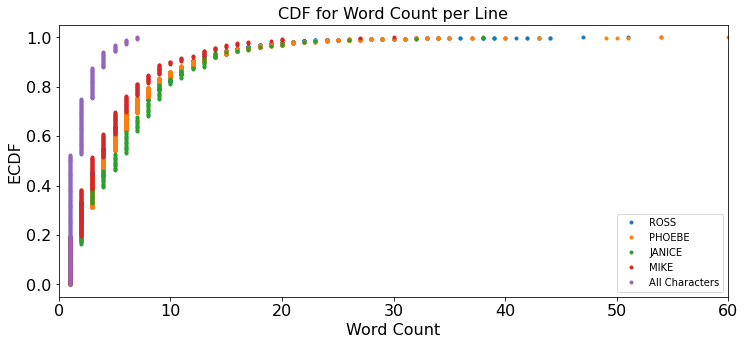

In [57]:
def ECDF(Character_Name1):
    if Character_Name1 in all_characters:
        word_count1    =  data["Lines"][data.Characters == Character_Name1].str.split(' ').str.len() 
    else: 
        word_count1    =  data["Lines"].str.split(' ').str.len()
    
           
    x1 = np.sort(word_count1)
    n1 = len(word_count1)
    y1 = np.arange(1, n1+1) / n1
    return x1,y1
    

x1,y1 = ECDF('ROSS')
x2,y2 = ECDF('PHOEBE')
x3,y3 = ECDF ('JANICE')
x4,y4 = ECDF ('MIKE')
x5,y5 = ECDF('ALL')

plt.figure(figsize = (12,5))

plt.plot(x1 , y1,marker = '.' , linestyle = 'none', label = 'ROSS')
plt.plot(x2 , y2 ,marker = '.' , linestyle = 'none', label = 'PHOEBE')
plt.plot(x3 , y3 ,marker = '.' , linestyle = 'none', label = 'JANICE')
plt.plot(x4 , y4,marker = '.' , linestyle = 'none', label = 'MIKE')
plt.plot(x5 , y5 ,marker = '.' , linestyle = 'none', label = 'All Characters')

# Label the axes
plt.xlabel('Word Count', fontsize= 16)
plt.ylabel('ECDF',fontsize= 16)
plt.xticks(  fontsize= 16)
plt.yticks(  fontsize= 16)
plt.title("CDF for Word Count per Line",fontsize=16)
#plt.legend(loc='lower right', bbox_to_anchor=(1.3, 1),prop={'size':10})
plt.legend(loc='lower right')
plt.xlim([0,60])
plt.show()


# Interactive EDA: WordCloud for Leading Actors

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
#from resizeimage import resizeimage
from collections import Counter

#define a function to plot word cloud

def show_wordcloud(data,Filter_Common_Words, Desired_Character = 'All Friends'):
    
    
    #define the image mask for word_cloud plot
  
    image = Image.open('{0}.png'.format( Desired_Character))
        
    mask = np.array(image)
    def transform_format(val):
        if val == 0:
            return 255
        else:
            return val
    
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    for i in range(len(mask)):
        transformed_mask[i] = list(map(transform_format, mask[i]))
    
    # Select a list of most common words to filter from the word cloud
    
    if Filter_Common_Words>0:
        
        #sort all word per their frequency and make a list to filter
        list1=all_words
        counts = Counter(list1)
        most_common = sorted(counts, key=counts.get, reverse=True)[0:Filter_Common_Words]
        
        #make sure that names of the characters are not in the filter
        most_common = [word  for word in most_common if not word.upper() in all_characters]
        most_common.append('NaN')

        wordcloud = WordCloud (stopwords=most_common,
                                width=800, height=400,
                                background_color = 'white',
                                scale =3,
                                max_words = 200, 
                                mask = transformed_mask,
                                random_state = 42, 
                                contour_width=3, contour_color='steelblue'
                             ).generate(str(data))
    else:
         wordcloud = WordCloud (width=800, height=400,
                                background_color = 'white',
                                scale =3,
                                max_words = 250, 
                                mask = transformed_mask,
                                random_state = 42, 
                                contour_width=3, contour_color='steelblue',
                                collocations = False,
                             ).generate(str(data))
        
    # plot wordcloud
    fig = plt.figure(1, figsize = (10, 10))
    plt.title('WordCloud: {0}'.format(Desired_Character), fontsize = 32, loc= 'center')
    plt.axis('off')
    
    fig.subplots_adjust(top = 2.3)
    
    plt.tight_layout()
    # show plot
    plt.imshow(wordcloud,interpolation='bilinear')

# Make a list of most common words

In [60]:
import ipywidgets as widgets

from ipywidgets import interact

def wordcloud_generator(Desired_Character, Filter_Common_Words):
    if Desired_Character in all_characters:
        show_wordcloud(data["Lines"][data.Characters == Desired_Character], Filter_Common_Words, Desired_Character)
    else:
         show_wordcloud(data["Lines"], Filter_Common_Words)
     
# features to visualize


style = {'description_width': 'initial'}
slider_range = widgets.IntSlider(value=1000, min=0, max=15149,style=style)
slider_range.style.handle_color = 'lightblue'

origin = widgets.Dropdown(
    options=list( ['ROSS','MONICA','RACHEL','PHOEBE','JOEY','CHANDLER', 'All Friends']),
    description='Desired_Character',style = style)
    
interact(wordcloud_generator, Desired_Character = origin, Filter_Common_Words = slider_range,style = style)


interactive(children=(Dropdown(description='Desired_Character', options=('ROSS', 'MONICA', 'RACHEL', 'PHOEBE',…

<function __main__.wordcloud_generator(Desired_Character, Filter_Common_Words)>

# Export DataFrame for Further Analysis

In [ ]:
#There are 305 chacracters, lets limit the analysis for top 15 to simplify the project
# import data
data.to_csv('data_clean.csv', encoding = 'utf-8')


In [61]:
threshold = 15
data = data[data.Characters.isin(Characters_per_rank[0:threshold])]
tokenized_data = data["Lines"].apply(lambda text: re.split(' ',text))
my_tags = Characters_per_rank[0:threshold]
# Label Character
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
target = label.fit_transform(data['Characters'].astype(str))

# Latent Semantic and Sentiment Analysis

In [ ]:
is_char = data.Characters.isin(['PHOEBE','ROSS','CHANDLER','JOEY','MONICA','RACHEL'])
friends_char_df = data[is_char]
friends_char_df

In [15]:
phoebe_text = list(friends_char_df[friends_char_df.Characters == 'PHOEBE'].Lines)
ross_text = list(friends_char_df[friends_char_df.Characters == 'ROSS'].Lines)
chandler_text = list(friends_char_df[friends_char_df.Characters == 'CHANDLER'].Lines)
joey_text = list(friends_char_df[friends_char_df.Characters == 'JOEY'].Lines)
monica_text = list(friends_char_df[friends_char_df.Characters == 'MONICA'].Lines)
rachel_text = list(friends_char_df[friends_char_df.Characters == 'RACHEL'].Lines)

In [16]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # stem tokens
        
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [17]:
from gensim import corpora
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [18]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """

    d,dtm=prepare_corpus(doc_clean)
    lsa = LsiModel(dtm, num_topics=number_of_topics, id2word = d)
    return lsa 

In [19]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(term_dictionary, doc_term_matrix, cleaned_documents_list, start, stop, step):
    """
    Input: term_dictionary, doc_term_matrix, cleaned_documents_list, 
           start(Min. number of topics),
           stop(Max. num of topics)
           step(Step size when increasing the number of topics) 
    Output  : coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    # YOUR CODE HERE
    
    mlist = []
    cval = []
    for n in range(start, stop, step):
        m = LsiModel(doc_term_matrix, num_topics=n, id2word = term_dictionary)  
        mlist.append(m)
        cval.append(CoherenceModel(model=m, texts=cleaned_documents_list, dictionary=term_dictionary, coherence='c_v').get_coherence())
    return cval

In [20]:
def plot_graph(coherence_values,start, stop, step):
    '''
    Input: Coherence Values, Start, Stop, Step
    Output: N/A(Should not return anything, but should plot the graph between the number of topics and coherence values.)
    '''
    # YOUR CODE HERE
    plt.plot(range(start, stop, step), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.show()
    return

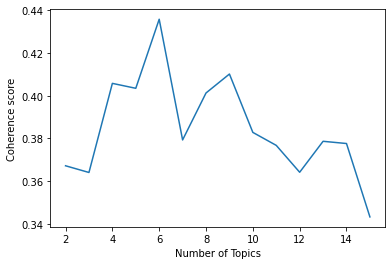

In [31]:
start,stop,step=2,16,1
clean_documents_list=preprocess_data(phoebe_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

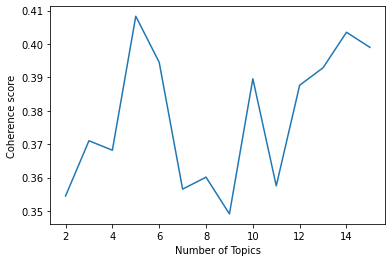

In [30]:
start,stop,step=2,16,1
clean_documents_list=preprocess_data(ross_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

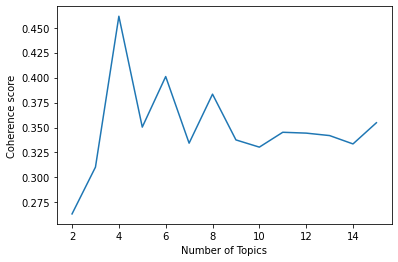

In [24]:
start,stop,step=2,16,1
clean_documents_list=preprocess_data(monica_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

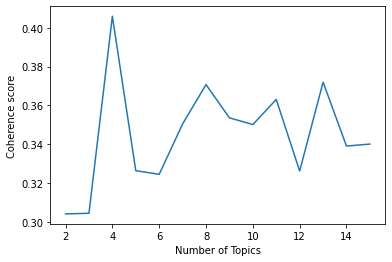

In [25]:
start,stop,step=2,16,1
clean_documents_list=preprocess_data(chandler_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

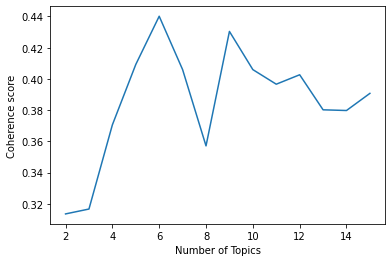

In [26]:
start,stop,step=2,16,1
clean_documents_list=preprocess_data(joey_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

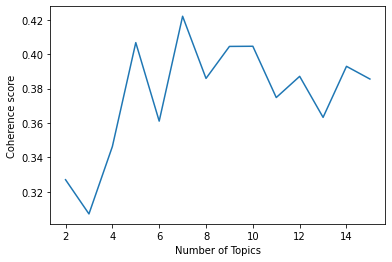

In [33]:
start,stop,step=2,16,1
clean_documents_list=preprocess_data(rachel_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

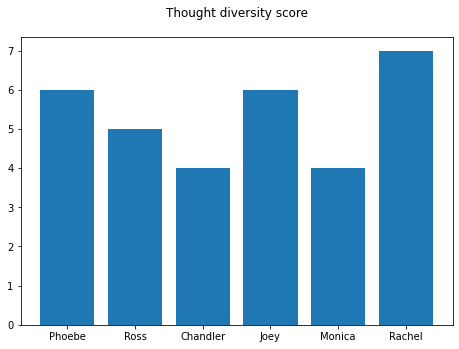

In [34]:
lchar = ['Phoebe','Ross','Chandler','Joey','Monica','Rachel']
ltopics =[6,5,4,6,4,7]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Thought diversity score', pad=20)
ax.bar(lchar,ltopics)
plt.show()

In [63]:
number_of_topics=9
words=20
model=create_gensim_lsa_model(preprocess_data(rachel_text),number_of_topics,words)
rachel_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
rachel_topics

[(0,
  '-0.670*"oh" + -0.424*"know" + -0.193*"okay" + -0.181*"get" + -0.169*"god" + -0.140*"well" + -0.137*"go" + -0.134*"gonna" + -0.124*"mean" + -0.123*"yeah" + -0.115*"think" + -0.114*"ross" + -0.114*"like" + -0.112*"right" + -0.093*"realli" + -0.084*"want" + -0.081*"look" + -0.081*"guy" + -0.072*"say" + -0.071*"come"'),
 (1,
  '-0.671*"oh" + 0.559*"know" + 0.198*"okay" + -0.191*"god" + 0.140*"get" + 0.137*"well" + 0.129*"mean" + 0.109*"gonna" + 0.107*"right" + 0.099*"go" + 0.098*"think" + 0.070*"like" + 0.066*"yeah" + 0.064*"say" + 0.054*"want" + 0.052*"realli" + 0.050*"guy" + 0.047*"ross" + 0.047*"would" + 0.044*"one"'),
 (2,
  '0.786*"okay" + -0.506*"know" + 0.201*"get" + 0.125*"right" + 0.122*"gonna" + 0.106*"go" + -0.071*"oh" + -0.067*"mean" + 0.065*"see" + 0.051*"well" + 0.051*"let" + 0.040*"come" + 0.040*"ross" + 0.037*"uh" + 0.037*"umm" + 0.036*"tell" + 0.036*"wait" + -0.028*"think" + -0.026*"yeah" + 0.025*"one"'),
 (3,
  '0.458*"okay" + -0.458*"well" + -0.429*"get" + 0.396*

In [64]:
number_of_topics=9
words=20
model=create_gensim_lsa_model(preprocess_data(monica_text),number_of_topics,words)
monica_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
monica_topics

[(0,
  '-0.400*"oh" + -0.392*"get" + -0.375*"know" + -0.295*"go" + -0.268*"okay" + -0.178*"gonna" + -0.157*"right" + -0.150*"god" + -0.148*"mean" + -0.139*"think" + -0.133*"want" + -0.129*"realli" + -0.128*"like" + -0.114*"well" + -0.098*"see" + -0.096*"yeah" + -0.094*"look" + -0.090*"say" + -0.088*"make" + -0.087*"come"'),
 (1,
  '0.818*"oh" + 0.337*"god" + -0.271*"get" + -0.199*"know" + -0.186*"go" + -0.154*"okay" + -0.077*"think" + -0.064*"mean" + -0.064*"want" + -0.050*"well" + -0.042*"realli" + -0.040*"say" + -0.036*"right" + -0.036*"someth" + -0.034*"like" + -0.034*"one" + -0.032*"thing" + -0.031*"umm" + -0.028*"make" + -0.026*"time"'),
 (2,
  '0.768*"get" + -0.580*"know" + -0.110*"mean" + -0.086*"think" + -0.084*"like" + -0.071*"realli" + -0.055*"want" + 0.055*"oh" + -0.050*"say" + -0.047*"well" + -0.047*"look" + 0.043*"god" + -0.037*"chandler" + -0.037*"thing" + -0.037*"make" + 0.035*"marri" + -0.034*"right" + -0.034*"would" + 0.030*"go" + -0.030*"good"'),
 (3,
  '-0.714*"okay"

In [65]:
number_of_topics=9
words=20
model=create_gensim_lsa_model(preprocess_data(ross_text),number_of_topics,words)
ross_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
ross_topics

[(0,
  '-0.494*"know" + -0.307*"okay" + -0.280*"oh" + -0.264*"uh" + -0.230*"get" + -0.214*"go" + -0.213*"yeah" + -0.166*"mean" + -0.155*"well" + -0.155*"like" + -0.149*"right" + -0.143*"think" + -0.141*"hey" + -0.130*"look" + -0.119*"guy" + -0.114*"want" + -0.114*"gonna" + -0.107*"come" + -0.103*"say" + -0.093*"realli"'),
 (1,
  '0.842*"okay" + -0.326*"oh" + -0.313*"know" + -0.167*"yeah" + 0.104*"go" + -0.090*"uh" + 0.063*"get" + 0.062*"look" + 0.060*"right" + -0.054*"god" + 0.052*"hey" + 0.048*"let" + 0.043*"gonna" + -0.041*"mean" + -0.040*"like" + -0.028*"think" + -0.027*"realli" + 0.024*"see" + -0.023*"guy" + 0.023*"take"'),
 (2,
  '-0.773*"oh" + 0.567*"know" + -0.118*"god" + -0.118*"okay" + -0.111*"yeah" + -0.098*"uh" + 0.078*"mean" + -0.062*"hey" + -0.042*"get" + 0.037*"say" + -0.033*"come" + 0.032*"think" + 0.030*"go" + -0.028*"thank" + 0.027*"guy" + 0.024*"would" + 0.021*"want" + 0.021*"one" + -0.020*"great" + 0.018*"like"'),
 (3,
  '-0.647*"yeah" + -0.535*"uh" + 0.361*"oh" + 0.

In [66]:
number_of_topics=9
words=20
model=create_gensim_lsa_model(preprocess_data(phoebe_text),number_of_topics,words)
phoebe_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
phoebe_topics

[(0,
  '-0.577*"know" + -0.476*"oh" + -0.287*"okay" + -0.206*"like" + -0.188*"yeah" + -0.183*"get" + -0.151*"well" + -0.145*"go" + -0.115*"gonna" + -0.114*"realli" + -0.113*"right" + -0.109*"guy" + -0.102*"think" + -0.087*"look" + -0.087*"god" + -0.083*"one" + -0.072*"say" + -0.072*"mean" + -0.070*"want" + -0.064*"good"'),
 (1,
  '0.798*"oh" + -0.549*"know" + 0.145*"god" + -0.118*"like" + -0.050*"well" + -0.048*"realli" + -0.047*"think" + -0.043*"gonna" + -0.041*"mean" + -0.033*"okay" + 0.029*"hi" + -0.027*"say" + 0.026*"thank" + 0.025*"wait" + 0.022*"look" + -0.020*"mayb" + -0.019*"would" + -0.019*"want" + 0.018*"hey" + -0.018*"get"'),
 (2,
  '-0.809*"okay" + 0.423*"know" + 0.235*"oh" + -0.131*"right" + -0.123*"go" + -0.120*"well" + -0.115*"get" + -0.079*"gonna" + 0.064*"like" + 0.057*"god" + -0.057*"umm" + -0.047*"come" + -0.040*"good" + -0.038*"look" + -0.038*"let" + -0.037*"say" + -0.037*"take" + -0.031*"one" + -0.030*"see" + -0.030*"hey"'),
 (3,
  '0.891*"yeah" + -0.263*"okay" + -

In [67]:
number_of_topics=9
words=20
model=create_gensim_lsa_model(preprocess_data(joey_text),number_of_topics,words)
joey_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
joey_topics

[(0,
  '0.448*"know" + 0.305*"hey" + 0.297*"get" + 0.290*"yeah" + 0.253*"oh" + 0.214*"right" + 0.214*"like" + 0.187*"go" + 0.184*"look" + 0.173*"uh" + 0.169*"okay" + 0.149*"well" + 0.128*"guy" + 0.118*"think" + 0.111*"say" + 0.111*"gonna" + 0.099*"ross" + 0.095*"want" + 0.095*"one" + 0.092*"come"'),
 (1,
  '0.894*"hey" + -0.323*"yeah" + -0.258*"know" + -0.090*"like" + -0.054*"oh" + -0.050*"well" + 0.043*"ross" + -0.036*"think" + -0.034*"realli" + 0.031*"guy" + -0.031*"mean" + -0.023*"see" + 0.022*"listen" + -0.022*"want" + 0.018*"rach" + -0.018*"okay" + -0.017*"thing" + 0.016*"come" + -0.015*"would" + 0.015*"let"'),
 (2,
  '-0.643*"yeah" + 0.600*"know" + -0.433*"oh" + 0.076*"look" + -0.075*"hey" + -0.067*"uh" + 0.054*"guy" + 0.049*"like" + 0.044*"mean" + 0.042*"think" + 0.031*"gonna" + 0.030*"want" + -0.029*"okay" + 0.028*"could" + 0.025*"realli" + -0.022*"god" + 0.017*"tell" + 0.017*"never" + 0.016*"make" + 0.016*"way"'),
 (3,
  '0.477*"know" + 0.456*"yeah" + -0.427*"get" + -0.333*"ri

In [68]:
number_of_topics=9
words=20
model=create_gensim_lsa_model(preprocess_data(chandler_text),number_of_topics,words)
chandler_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
chandler_topics

[(0,
  '-0.601*"know" + -0.302*"get" + -0.265*"go" + -0.226*"okay" + -0.202*"oh" + -0.182*"well" + -0.170*"gonna" + -0.162*"think" + -0.153*"like" + -0.142*"look" + -0.131*"right" + -0.126*"yeah" + -0.122*"say" + -0.110*"mean" + -0.105*"guy" + -0.098*"one" + -0.098*"want" + -0.089*"see" + -0.083*"uh" + -0.081*"hey"'),
 (1,
  '-0.688*"know" + 0.459*"okay" + 0.374*"oh" + 0.240*"get" + 0.194*"go" + 0.113*"right" + 0.110*"yeah" + 0.068*"gonna" + -0.060*"like" + 0.055*"look" + 0.052*"god" + 0.050*"well" + 0.049*"say" + 0.047*"come" + 0.047*"joey" + 0.042*"ye" + 0.041*"uh" + 0.039*"let" + 0.039*"hey" + 0.037*"one"'),
 (2,
  '-0.704*"oh" + 0.483*"okay" + 0.418*"go" + -0.193*"yeah" + -0.104*"get" + -0.093*"god" + 0.091*"gonna" + -0.068*"well" + 0.067*"look" + -0.053*"hey" + -0.044*"good" + -0.040*"come" + -0.035*"ye" + -0.030*"thank" + -0.029*"uh" + 0.024*"right" + -0.023*"mean" + -0.023*"would" + -0.023*"great" + -0.021*"realli"'),
 (3,
  '-0.736*"get" + 0.550*"go" + 0.324*"oh" + -0.101*"okay

In [69]:
s= chandler_topics[0][1]
s.split('"')[1::2]

['know',
 'get',
 'go',
 'okay',
 'oh',
 'well',
 'gonna',
 'think',
 'like',
 'look',
 'right',
 'yeah',
 'say',
 'mean',
 'guy',
 'one',
 'want',
 'see',
 'uh',
 'hey']

In [70]:
lchar2 = [ 'rachel', 'ross','monica','phoebe',  'joey','chandler']
topics_list = [rachel_topics, ross_topics, monica_topics, phoebe_topics, joey_topics, chandler_topics]
character_affinity =[]
for i in range(len(lchar2)):
    tp = topics_list[i]
    ca = [0 for i in range(6)]
    for j in range(len(lchar2)):
        for k, t in enumerate(tp):
            s = t[1].split('"')[1::2]
            if(lchar2[j] in s):
                ca[j] = ca[j]+1
    character_affinity.append(ca)

ca_df = pd.DataFrame(character_affinity)
ca_df.columns =lchar2
ca_df.index = lchar2
ca_df
                

,rachel,ross,monica,phoebe,joey,chandler
rachel,0,9,0,0,1,0
ross,0,0,0,0,1,0
monica,1,1,0,0,2,2
phoebe,0,3,1,0,1,1
joey,0,5,0,0,0,0
chandler,0,0,2,0,5,0


Text(0.5, 1.0, 'Character affinity heat map')

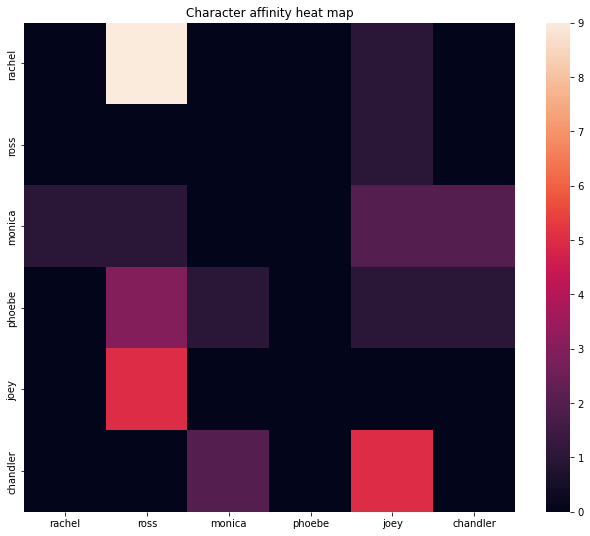

In [71]:
import seaborn as sb
#plotting character affinity heatmap 
#Higher affinity towards one character means higher mentions of another character in the other character's key topics through out
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(ca_df)

# displaying the title 
plt.title("Character affinity heat map")

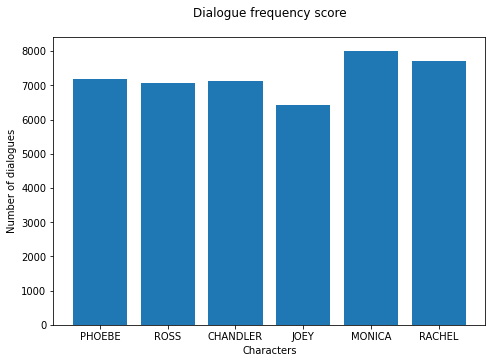

In [51]:
# Most important character by dialogues - Joey
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Dialogue frequency score", pad=20)
plt.xlabel('Characters')  
plt.ylabel('Number of dialogues') 
ax.bar(['PHOEBE','ROSS','CHANDLER','JOEY','MONICA','RACHEL'], friends_char_df.groupby(by=["Characters"]).count()['Lines'])

plt.show()

In [52]:
# using TextBlob.sentiment method 
from textblob import TextBlob 
all_char = ['PHOEBE','ROSS','CHANDLER','JOEY','MONICA','RACHEL']
for i in friends_char_df.index:
    dialogue = friends_char_df.loc[i,'Lines']
    tb = TextBlob(dialogue)
    s=0
    if(tb.sentiment[0]>0):
        s =1
    elif(tb.sentiment[0]<0):
        s=-1
    friends_char_df.loc[i,'Sentiment'] =s
friends_char_df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Episodes,Episode_Names,Characters,Lines,Season,Sentiment
0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1,0.0
1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1,-1.0
2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1,1.0
3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1,0.0
4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1,0.0
...,...,...,...,...,...,...
51761,1017-1018,"The Last One, Part I & II",CHANDLER,oh gonna okay,10,1.0
51762,1017-1018,"The Last One, Part I & II",RACHEL,guy go new house right away time,10,1.0
51763,1017-1018,"The Last One, Part I & II",MONICA,get time,10,0.0
51764,1017-1018,"The Last One, Part I & II",RACHEL,okay get coffee,10,1.0


In [53]:
actor_sentiment =[]
for actor in all_char:
    cp = friends_char_df[friends_char_df.Characters == actor][friends_char_df.Sentiment == 1].Sentiment.count()
    cn = friends_char_df[friends_char_df.Characters == actor][friends_char_df.Sentiment == 0].Sentiment.count()
    c = friends_char_df[friends_char_df.Characters == actor][friends_char_df.Sentiment == -1].Sentiment.count()
    s = cp+cn+c
    actor_sentiment.append([cp*100/s,c*100/s,cn*100/s])
actor_sentiment

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


[[36.55311868097682, 11.619225384974335, 51.82765593404884],
 [34.33727119304167, 12.332857328313644, 53.329871478644684],
 [34.76807354784789, 12.369410781445884, 52.86251567070622],
 [33.65888181174805, 11.861288039631988, 54.47983014861996],
 [33.370754981756946, 13.078866124052764, 53.55037889419029],
 [34.27716103280529, 12.872645628040415, 52.850193339154295]]

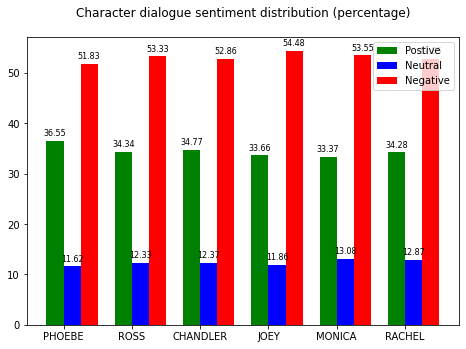

In [55]:
data_sent =  np.array(actor_sentiment).T.tolist()
X = np.arange(6)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
r1 =ax.bar(X + 0.00, data_sent[0], color = 'g', width= 0.25)
r2 =ax.bar(X + 0.25, data_sent[1], color = 'b', width = 0.25)
r3 =ax.bar(X + 0.50, data_sent[2], color = 'r', width = 0.25)
ax.legend(labels=['Postive', 'Neutral','Negative'])
ax.set_title("Character dialogue sentiment distribution (percentage)", pad=20)
plt.xticks(X + .25 /2, all_char)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)


autolabel(r1)
autolabel(r2)
autolabel(r3)

plt.show()